# 0. Install Dependencies

In [ ]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 1. Test Random Environment with OpenAI Gym

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box, Dict
import numpy as np
import random
import gym

In [ ]:
#Testing random selection of valid scenario
import numpy as np

# Generate the array of shape (3,50)
arr1 = np.array([i+1 for i in range(5)]*10)
arr2 = np.array([i+1 for i in range(5)]*10)
arr3 = np.array([i+1 for i in range(5)]*10)
np.random.shuffle(arr1)
np.random.shuffle(arr2)
np.random.shuffle(arr3)
combined_arr = np.array([arr1, arr2, arr3])
print(combined_arr)
# Iterate over the 50 arrays and find the indices where the value at that index is equal to i
i = 3
indices = []
print(combined_arr.shape)
for j in range(combined_arr.shape[1]):
    if combined_arr[0][j] == i: #if first box is 3, it is valid
        indices.append(j)

# Randomly select an index from the list of indices where the value at that index is equal to i
random_index = np.random.choice(indices)

# Select the array corresponding to the random index
selected_array = combined_arr[:,random_index]

print(selected_array)

[[3 3 4 1 1 5 3 2 1 2 3 4 2 4 5 4 2 4 1 5 2 1 5 2 1 5 4 3 4 3 5 3 1 1 2 2
  4 5 1 3 2 4 2 5 1 5 3 3 4 5]
 [5 5 3 5 3 5 3 4 1 3 1 2 4 2 1 4 5 1 2 2 1 2 2 2 5 2 3 4 1 2 4 5 4 4 1 3
  3 1 4 4 3 3 3 5 1 1 5 5 2 4]
 [5 4 1 1 2 3 3 1 4 2 4 3 3 3 4 5 1 4 5 1 2 1 2 4 5 4 4 3 1 5 5 2 3 4 5 2
  5 2 4 2 1 5 1 5 1 3 2 2 3 3]]
(3, 50)
[3 5 5]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class PandoraEnv(Env):
    def __init__(self, n=3,low=1,high=5,box_costs=np.full_like(np.zeros(3),1.2),v0=0):
        # Actions we can take, open which box or quit now
        self.action_space = Discrete(n+1)
        #range of values
        self.low=low
        self.high = high
        #Observation space (space of Available states)
        self.observation_space = Box(low=-10, high=self.high, shape=(1,7), dtype=np.int)
        # Set start state (n unopened boxes)
        
        #self.state = np.zeros((n,))

        #Set game parameters
        self.box_costs=box_costs
        #box number
        self.maxVal = v0;
        self.maxBox = -1;
        
        
        #number of boxes left to open
        self.n=n;
        #list of scenarios to describe correlated distribution
        # Create three arrays of size 100 containing the numbers 1-10
        arr1 = np.array([i+1 for i in range(5)]*10)
        arr2 = np.array([i+1 for i in range(5)]*10)
        arr3 = np.array([i+1 for i in range(5)]*10)
        # Shuffle each array
        np.random.shuffle(arr1)
        np.random.shuffle(arr2)
        np.random.shuffle(arr3)
        # Combine the arrays into a single array of shape (3,50)
        self.scenarios_list = np.array([arr1, arr2, arr3])
        #scenario is combined in line of shape (1,150)
        self.scenarios_in_line=np.concatenate((arr1,arr2,arr3),axis=0)
        #each scenario's possibility (1=possible, 0=impossible)
        self.possible_scenarios = np.ones(50)
        #number of possible scenarios
        self.num_pos_sce=50
        #track the value of opened boxes (0 if not opened)
        self.opened_boxes = np.zeros(self.n)
        #expected gain of opening box x
        self.exp_val=np.zeros(self.n)

        #current step
        self.current_step=0
        #current reward
        self.reward=v0
        self.v0=v0
        
    def find_val_scenario(self):
        indices = []
        sl = self.scenarios_list
        #list of values for opened boxes (0 if not opened)
        x = self.opened_boxes[0]
        y = self.opened_boxes[1]
        z = self.opened_boxes[2]
        #find indices of valid scenarios
        for j in range(sl.shape[1]):
          if sl[0][j] == x or x==0: 
            if sl[1][j] == y or y==0:
              if sl[2][j] == z or z==0:
                indices.append(j)

  
        # Randomly select an index from the list of indices where the value at that index is equal to i
        random_index = np.random.choice(indices)
        #return the index of chosen scenario
        return random_index
        # Select the array corresponding to the random index
        #return sl[:,random_index]

    def update_possible_scenarios(self):
        #list of values for opened boxes (0 if not opened)
        x = self.opened_boxes[0]
        y = self.opened_boxes[1]
        z = self.opened_boxes[2]

        sl = self.scenarios_list
        #Disable the scenarios that are not possible
        for j in range(sl.shape[1]):
          if sl[0][j] != x and x!=0 or sl[1][j] != y and y!=0 or sl[2][j] != z and z!=0: 
            #print("Invalid={},{},{}".format(sl[0][j] ,sl[1][j],sl[2][j]))
            self.possible_scenarios[j]=0
        return
    def update_exp_val(self):
        #list of values for opened boxes (0 if not opened)
        x = self.opened_boxes[0]
        y = self.opened_boxes[1]
        z = self.opened_boxes[2]

        sl = self.scenarios_list
        valid_entries = 0
        x_sum = 0
        y_sum = 0
        z_sum = 0
        #Disable the scenarios that are not possible
        for j in range(sl.shape[1]):
          if sl[0][j] != x and x!=0 or sl[1][j] != y and y!=0 or sl[2][j] != z and z!=0: 
            continue
          else:
            valid_entries += 1
            x_sum += sl[0][j]
            y_sum += sl[1][j]
            z_sum += sl[2][j]
        if valid_entries > 0:
          avg_x = x_sum / valid_entries
          avg_y = y_sum / valid_entries
          avg_z = z_sum / valid_entries
        else:
          avg_x = avg_y = avg_z = 0  
        ret=[avg_x,avg_y,avg_z]
        for i in range(3):
          if self.opened_boxes[i]!=0:
            ret[i]=-10
        self.exp_val = np.array(ret)
        return 

    def concat(self):
        # return np.concatenate((self.possible_scenarios.reshape(1, 50), 
        #                          self.scenarios_in_line),
        #                          np.array([[self.maxVal]]),
        #                          self.opened_boxes,  
        #                          axis=1)  
        #return np.concatenate((self.scenarios_in_line, np.array([[self.maxVal]]), self.opened_boxes.reshape(1, 3), np.array([[self.num_pos_sce]])), axis=1).reshape(155,)
        return np.concatenate((self.exp_val.reshape(1,3), self.opened_boxes.reshape(1, 3), np.array([[self.maxVal]])), axis=1).reshape(7,)
        
    def step(self, action):
        #assert self.action_space.contains(action)
        reward = 0
        #state as array of shape (1,7) (7=3(exp val of each box)+3(boxOpened)+1(maxVal))
        observation = self.concat()

        #choose to quit
        if action == self.n:          
            done = True
            #return [self.boxes_opened,self.maxVal], reward, done, {}
            return observation, reward, done, {}
       
        #Open box
        box_index = action
        #If open an opened box (negative reward)
        if self.opened_boxes[box_index]!=0:
            reward=-50
        #else choose the value from possible scenarios
        else:
            #box_value = np.random.uniform(low=self.box_ranges[box_index][0], high=self.box_ranges[box_index][1])
            scenario_index = self.find_val_scenario()
            #print('scenario={},{},{}'.format(self.scenarios_list[0][scenario_index],self.scenarios_list[1][scenario_index],self.scenarios_list[2][scenario_index]))
            #retrieve box_value from possible scenarios list
            box_value = self.scenarios_list[box_index][scenario_index]
            #print('box value={}'.format(box_value))
            self.opened_boxes[box_index]=box_value
            #update list of valid scenarios
            self.update_possible_scenarios()
            #update expected values of each box
            self.update_exp_val()

            #update reward
            reward -= self.box_costs[box_index]
            reward += max(0, box_value-self.maxVal)
            self.current_step+=1
            if self.maxVal < box_value:
                self.reward -= self.maxVal
                self.reward += box_value
                self.maxVal = box_value
                self.maxBox = action
        #check whether the step count is done
        if self.current_step >= self.n:
          done = True
        else: 
          done = False
        # observation={
        # 'boxes': self.boxes_opened,
        # 'max_value': np.array([self.maxVal], dtype=np.float32)
        # }
        observation = self.concat()
        return observation, reward, done, {}


    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        #list of scenarios to describe correlated distribution
        # Create three arrays of size 100 containing the numbers 1-10
        arr1 = np.array([i+1 for i in range(5)]*10)
        arr2 = np.array([i+1 for i in range(5)]*10)
        arr3 = np.array([i+1 for i in range(5)]*10)
        # Shuffle each array
        np.random.shuffle(arr1)
        np.random.shuffle(arr2)
        np.random.shuffle(arr3)
        # Combine the arrays into a single array of shape (3,50)
        self.scenarios_list = np.array([arr1, arr2, arr3])
        #scenario is combined in line of shape (1,150)
        self.scenarios_in_line=np.concatenate((arr1,arr2,arr3),axis=0).reshape(1,150)
        #each scenario's possibility
        self.possible_scenarios = np.ones(50)
        #number of possible scenarios
        self.num_pos_sce=50
        #track the value of opened boxes (0 if not opened)
        self.opened_boxes = np.zeros(self.n)

        #current step
        self.current_step=0
        #current reward
        self.reward=self.v0
        self.maxBox=-1
        self.maxVal=self.v0

        #reset expected value
        self.exp_val=np.zeros(self.n)

 
        self.action_space = Discrete(self.n+1)
 
        observation = self.concat()
        return observation
    

In [ ]:
env = PandoraEnv()

<ipython-input-4-73f5f7c36ebe>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.observation_space = Box(low=-10, high=self.high, shape=(1,7), dtype=np.int)


In [ ]:
env.observation_space.sample()

array([[-4,  3,  1, -7, -1, -2, -4]])

In [ ]:
env.scenarios_list.shape

(3, 50)

In [ ]:
episodes = 10
total=0
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        print(n_state)
        score += reward
        
        print('Action:', action)
    total+=score    
    print('Episode:{} Score:{}'.format(episode, score))
print('average: {}'.format(total/episodes))

[0. 0. 0. 0. 0. 0. 0.]
Action: 3
Episode:1 Score:0
[  2.9   2.9 -10.    0.    0.    3.    3. ]
Action: 2
[  2.9   2.9 -10.    0.    0.    3.    3. ]
Action: 2
[  2.9   2.9 -10.    0.    0.    3.    3. ]
Action: 3
Episode:2 Score:-48.2
[-10.    3.7   2.7   1.    0.    0.    1. ]
Action: 0
[-10.    3.7   2.7   1.    0.    0.    1. ]
Action: 0
[-10.   5. -10.   1.   0.   4.   4.]
Action: 2
[-10. -10. -10.   1.   5.   4.   5.]
Action: 1
Episode:3 Score:-48.60000000000001
[-10.    3.1   3.2   3.    0.    0.    3. ]
Action: 0
[-10.    3.1   3.2   3.    0.    0.    3. ]
Action: 3
Episode:4 Score:1.8
[0. 0. 0. 0. 0. 0. 0.]
Action: 3
Episode:5 Score:0
[-10.    3.1   3.7   3.    0.    0.    3. ]
Action: 0
[-10.         -10.           2.66666667   3.           3.
   0.           3.        ]
Action: 1
[-10.         -10.           2.66666667   3.           3.
   0.           3.        ]
Action: 0
[-10. -10. -10.   3.   3.   2.   3.]
Action: 2
Episode:6 Score:-50.6
[  3.5 -10.    2.7   0.    3.    0

# 2. Create a Deep Learning Model with Keras

In [ ]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
actions

4

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Flatten(input_shape=(1, 7))) #(1,n+1)
    model.add(Dense(25, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
#del model 

NameError: ignored

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 25)                200       
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 4)                 104       
                                                                 
Total params: 954
Trainable params: 954
Non-trainable params: 0
_________________________________________________________________


# 3. Build Agent with Keras-RL (DQN)

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
class Metrics(keras.callbacks.Callback):
    def __init__(self, agent):
        keras.callbacks.Callback.__init__
        self.agent = agent
        
    def on_train_begin(self, logs={}):
        self.metrics = {key : [] for key in self.agent.metrics_names}

    def on_step_end(self, episode_step, logs):
        for ordinal, key in enumerate(self.agent.metrics_names, 0):
            self.metrics[key].append(logs.get('metrics')[ordinal])

In [ ]:
dqn = build_agent(model, actions)
#dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.compile(Adam(lr=1e-3), metrics = ['mae'])
metrics=Metrics(dqn)
history = dqn.fit(env, nb_steps=30000, visualize=False, verbose=1,callbacks=[metrics])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training for 30000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 25:50 - reward: -0.2000

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


   18/10000 [..............................] - ETA: 15:35 - reward: -16.0889

/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 13 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 15 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 16 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 17 + 1) instead
  batch_idxs

   28/10000 [..............................] - ETA: 11:00 - reward: -13.7357

/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 22 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 23 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 24 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 25 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 26 + 1) instead
  batch_idxs

10000/10000 [==============================] - 123s 12ms/step - reward: 0.5339
4086 episodes - episode_reward: 1.307 [-348.400, 3.800] - loss: 4.341 - mae: 8.771 - mean_q: 1.018

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 114s 11ms/step - reward: 0.6323
3975 episodes - episode_reward: 1.590 [-2.600, 3.800] - loss: 0.351 - mae: 9.577 - mean_q: 1.012

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 131s 13ms/step - reward: 0.6222
done, took 369.073 seconds


In [ ]:
metrics.metrics.keys()

dict_keys(['loss', 'mae', 'mean_q'])

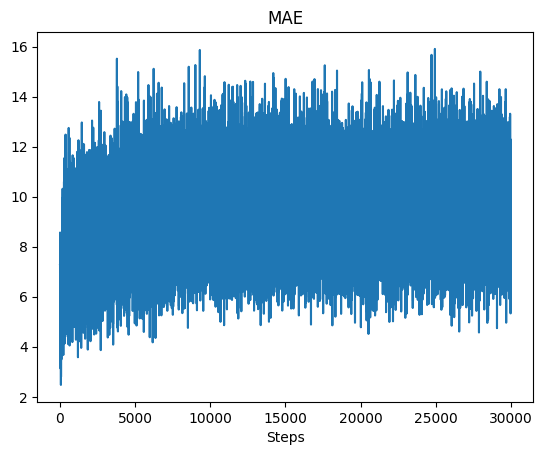

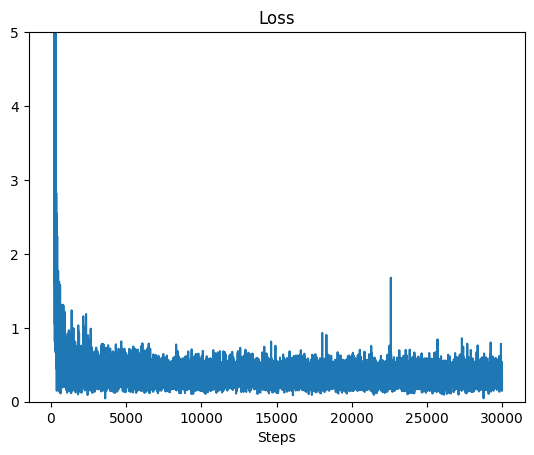

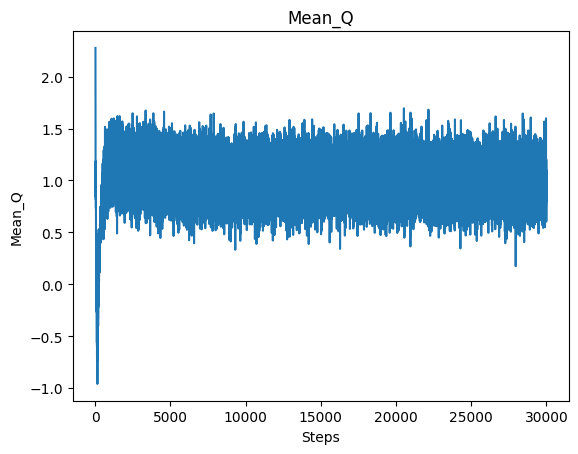

In [ ]:
import matplotlib.pyplot as plt

plt.plot(metrics.metrics['mae'])
plt.title('MAE')
plt.xlabel('Steps')
#plt.ylabel('MAE')
#plt.ylim([0, 1]) # set y-axis limits
plt.show()

plt.plot(metrics.metrics['loss'])
plt.title('Loss')
plt.xlabel('Steps')
#plt.ylabel('Loss')
plt.ylim([0, 5]) # set y-axis limits
plt.show()

plt.plot(metrics.metrics['mean_q'])
plt.title('Mean_Q')
plt.xlabel('Steps')
plt.ylabel('Mean_Q')
#plt.ylim([0, 1]) # set y-axis limits
plt.show()

#Deep SARSA

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from rl.agents import SARSAAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory


In [ ]:
# define your model (Deep SARSA)
modell = Sequential()
modell.add(Flatten(input_shape=(1,7)))
modell.add(Dense(50, activation='relu'))
modell.add(Dense(50, activation='relu'))
modell.add(Dense(actions, activation='linear'))

# set up optimizer and compile the model
optimizer = Adam(lr=1e-3)
modell.compile(loss='mse', optimizer=optimizer)


# set up the policy and memory
policy = EpsGreedyQPolicy(eps=0.1)

# set up the agent
sarsa = SARSAAgent(model=modell, nb_actions=env.action_space.n, policy=policy)
metricsSA=Metrics(sarsa)
sarsa.compile(optimizer=optimizer, metrics=['mae'])

# train the agent
historySA=sarsa.fit(env, nb_steps=10000, visualize=False, verbose=1,callbacks=[metricsSA])

Training for 10000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 98s 10ms/step - reward: -0.6071
done, took 98.046 seconds


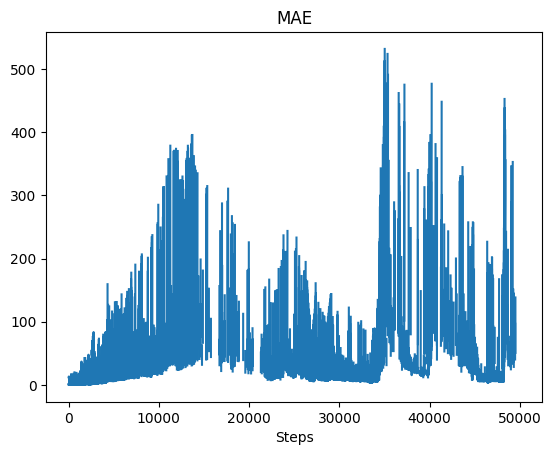

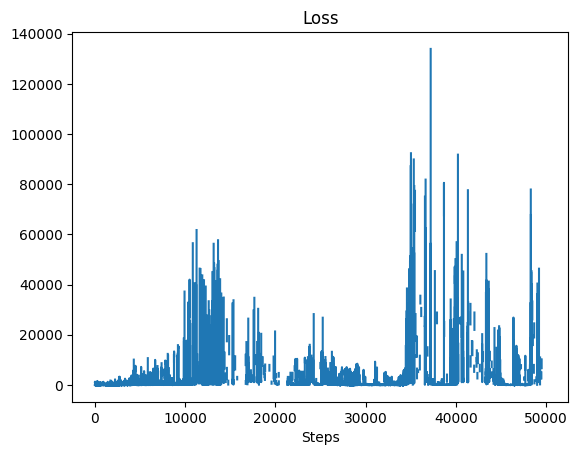

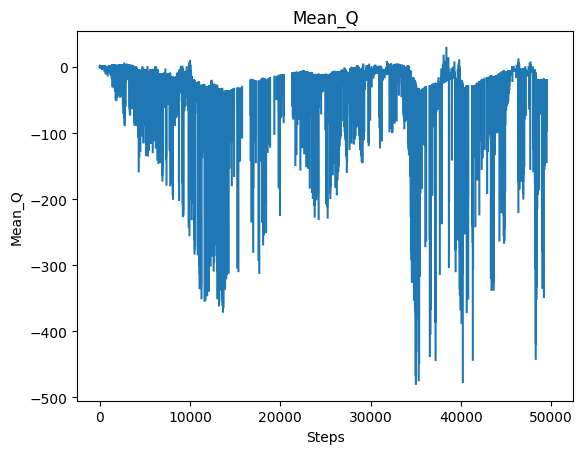

In [ ]:
import matplotlib.pyplot as plt

plt.plot(metricsSA.metrics['mae'])
plt.title('MAE')
plt.xlabel('Steps')
#plt.ylabel('MAE')
#plt.ylim([0, 1]) # set y-axis limits
plt.show()

plt.plot(metricsSA.metrics['loss'])
plt.title('Loss')
plt.xlabel('Steps')
#plt.ylabel('Loss')
#plt.ylim([0, 0.02]) # set y-axis limits
plt.show()

plt.plot(metricsSA.metrics['mean_q'])
plt.title('Mean_Q')
plt.xlabel('Steps')
plt.ylabel('Mean_Q')
#plt.ylim([0, 1]) # set y-axis limits
plt.show()

In [ ]:
st = sarsa.test(env, nb_episodes=100, visualize=False)
print(np.mean(st.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: 0.000, steps: 1
Episode 2: reward: 0.000, steps: 1
Episode 3: reward: 0.000, steps: 1
Episode 4: reward: 0.000, steps: 1
Episode 5: reward: 0.000, steps: 1
Episode 6: reward: 0.000, steps: 1
Episode 7: reward: 0.000, steps: 1
Episode 8: reward: 0.000, steps: 1
Episode 9: reward: 0.000, steps: 1
Episode 10: reward: 0.000, steps: 1
Episode 11: reward: 0.000, steps: 1
Episode 12: reward: 0.000, steps: 1
Episode 13: reward: 0.000, steps: 1
Episode 14: reward: 0.000, steps: 1
Episode 15: reward: 0.000, steps: 1
Episode 16: reward: 0.000, steps: 1
Episode 17: reward: 0.000, steps: 1
Episode 18: reward: 0.000, steps: 1
Episode 19: reward: 0.000, steps: 1
Episode 20: reward: 0.000, steps: 1
Episode 21: reward: 0.000, steps: 1
Episode 22: reward: 0.000, steps: 1
Episode 23: reward: 0.000, steps: 1
Episode 24: reward: 0.000, steps: 1
Episode 25: reward: 0.000, steps: 1
Episode 26: reward: 0.000, steps: 1
Episode 27: reward: 0.000, steps: 1
Episode 

##show Q-value at certain state

In [ ]:
# #Show Q-value
# np.set_printoptions(precision=4, suppress=True)
# for i in range(1,6):
  
#   state = np.array([3, -10, -10, 0, 1, 1, i])
#   #next_action = dqn.forward(state)

#   #state = np.array([0,1,0,1,0,1,i])
#   state = np.expand_dims(state, axis=0)  # Add an extra dimension
#   state = np.expand_dims(state, axis=1)  # Add another dimension for the timesteps
#   q_val = dqn.model.predict(state)
#   print("x={}".format(i))
#   print(q_val)
#   #print(next_action)

np.set_printoptions(precision=4, suppress=True)
state = [3, -10, -10, 0, 1, 1, 1.8]
state = np.expand_dims(state, axis=0)  # Add an extra dimension
state = np.expand_dims(state, axis=1)  # Add another dimension for the timesteps
q_val = dqn.model.predict(state)
print("x=1.8")
print(q_val)
state = [3, -10, -10, 0, 1, 1, 1.9]
state = np.expand_dims(state, axis=0)  # Add an extra dimension
state = np.expand_dims(state, axis=1)  # Add another dimension for the timesteps
q_val = dqn.model.predict(state)
print("x=1.9")
print(q_val)
state = [3, -10, -10, 0, 1, 1, 2.0]
state = np.expand_dims(state, axis=0)  # Add an extra dimension
state = np.expand_dims(state, axis=1)  # Add another dimension for the timesteps
print("x=2.0")
print(q_val)
state = [3, -10, -10, 0, 1, 1, 2.1]
state = np.expand_dims(state, axis=0)  # Add an extra dimension
state = np.expand_dims(state, axis=1)  # Add another dimension for the timesteps
q_val = dqn.model.predict(state)
#print(q_val)

x=1.8
[[  0.0522 -47.3765 -46.9273   0.0465]]
x=1.9
[[  0.0141 -47.2114 -47.0409   0.0421]]
x=2.0
[[  0.0141 -47.2114 -47.0409   0.0421]]


#Performance Comparison

In [ ]:
#S1) Simulation of DQN
scores = dqn.test(env, nb_episodes=100000, visualize=False)
print(np.mean(scores.history['episode_reward']))

Streaming output truncated to the last 5000 lines.
Episode 95002: reward: 1.600, steps: 3
Episode 95003: reward: 2.800, steps: 2
Episode 95004: reward: 1.800, steps: 2
Episode 95005: reward: 1.800, steps: 2
Episode 95006: reward: 0.800, steps: 2
Episode 95007: reward: 2.600, steps: 3
Episode 95008: reward: 1.600, steps: 3
Episode 95009: reward: 1.600, steps: 3
Episode 95010: reward: 1.800, steps: 2
Episode 95011: reward: 2.800, steps: 2
Episode 95012: reward: 3.800, steps: 2
Episode 95013: reward: 1.800, steps: 2
Episode 95014: reward: -0.600, steps: 3
Episode 95015: reward: 0.400, steps: 3
Episode 95016: reward: 1.800, steps: 2
Episode 95017: reward: 0.600, steps: 3
Episode 95018: reward: 2.800, steps: 2
Episode 95019: reward: 2.600, steps: 3
Episode 95020: reward: 1.400, steps: 3
Episode 95021: reward: 3.800, steps: 2
Episode 95022: reward: 1.800, steps: 2
Episode 95023: reward: 3.800, steps: 2
Episode 95024: reward: 3.800, steps: 2
Episode 95025: reward: 3.800, steps: 2
Episode 9502

In [ ]:
#S3) Best possible reward
import random

n = 100000
total_diff = 0

for i in range(n):
    nums = [random.randint(1, 5) for j in range(5)]
    max_num = max(nums)
    diff = max_num - 1.2
    total_diff += diff

average_diff = total_diff / n
print(average_diff)

3.3860299999936614


In [64]:
#S2) Fully Adaptive strategy
import numpy as np
import itertools

def s2(combined_arr):
    n = combined_arr.shape[1]
    selected_cols = set()
    R = set(range(combined_arr.shape[0]))
    max_v = float('-inf')
    num=0
    while len(selected_cols) < n:
        num+=1
        z_values = []
        for x in range(combined_arr.shape[1]):
            if x in selected_cols:
                z_values.append(float('-inf'))
                continue
                
            sorted_R = sorted(list(R), key=lambda a: combined_arr[a][x])
            max_z = float('-inf')
            best_subset = set()
            for i in range(len(sorted_R)):
                subset = set(sorted_R[:i+1])
                size_A = len(subset)
                sum_A = sum([combined_arr[a][x] for a in subset])
                z = (-1.2*len(list(R)) + sum_A)/size_A
                if z > max_z:
                    max_z = z
                    best_subset = subset
            
            z_values.append(max_z)
            
        max_z_index = np.argmax(z_values)
        x = max_z_index
        selected_cols.add(x)
        #print(R)
        A = best_subset
        a = np.random.choice(list(R))
        k = combined_arr[a][x]
        print("{},{}".format(k,z_values[x]))
        if k > z_values[x]:
            return k - 1.2*num
        
        R = set([i for i in R if combined_arr[i][x] == k])
        
        
        if k > max_v:
            max_v = k
    
    return max_v - 1.2*3
n=100000
tot = 0
for i in range(n):
  
  # Generate the array of shape (3,50)
  arr1 = np.array([i+1 for i in range(5)]*10)
  arr2 = np.array([i+1 for i in range(5)]*10)
  arr3 = np.array([i+1 for i in range(5)]*10)
  np.random.shuffle(arr1)
  np.random.shuffle(arr2)
  np.random.shuffle(arr3)
  combined_arr = np.array([arr1, arr2, arr3])
  combined_arr = combined_arr.T

  # test the function
  max_val = s2(combined_arr)
  tot+=max_val
print(tot/n)

#Average value = 2.035
#the code works well on a separte python IDE (Has collision with function sum() here)

TypeError: ignored

In [ ]:
def find_max_value(combined_arr, n):
    selected_cols = []
    rows = [i for i in range(combined_arr.shape[0])]
    max_val = float('-inf')
    for i in range(n):
        cols = [j for j in range(combined_arr.shape[1]) if j not in selected_cols]
        if not cols:
            break
        x = random.choice(cols)
        selected_cols.append(x)
        a = random.choice(rows)
        v = combined_arr[a, x]
        rows = [j for j in rows if combined_arr[j, x] == v]
        if v > max_val:
            max_val = v
    return max_val

In [ ]:
#S1)
n=100000
for k in range(1,4):
  total = 0
  for i in range(n):
    arr1 = np.array([i+1 for i in range(5)]*10)
    arr2 = np.array([i+1 for i in range(5)]*10)
    arr3 = np.array([i+1 for i in range(5)]*10)
    np.random.shuffle(arr1)
    np.random.shuffle(arr2)
    np.random.shuffle(arr3)
    combined_arr = np.array([arr1, arr2, arr3])
    combined_arr = combined_arr.T
    total +=find_max_value(combined_arr,k)-k*1.2
  print("k={}".format(total/n))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


k=1.8085399999982896
k=1.3993800000026027
k=0.6029500000009873


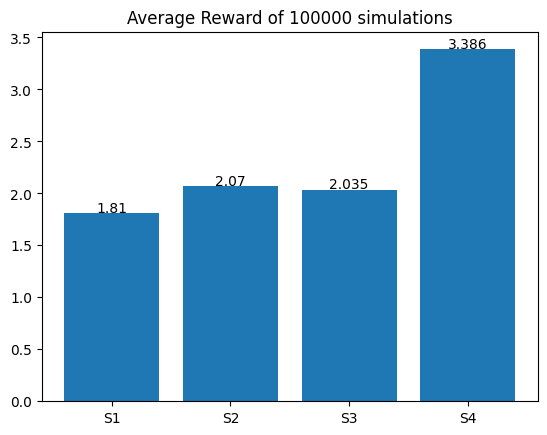

In [65]:
import matplotlib.pyplot as plt

# Define data
x = ['S1', 'S2',  'S3','S4']
y = [1.81, 2.07,2.035 ,3.386]

# Create bar chart
fig, ax = plt.subplots()
ax.bar(x, y)

# Add values above each bar
for i, v in enumerate(y):
    ax.text(i, v+0.01, str(v), ha='center')

# Set chart title and axis labels
ax.set_title('Average Reward of 100000 simulations')
#ax.set_ylabel('Average Reward')


# Show the chart
plt.show()